# Evaluation
In this final notebook, we load the two trained models and evaluate them on the validation set.

## Load data

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse

df_val_impressions = pd.read_csv('data/large/dev/processed/two_tower_interactions.csv')  # it is the two tower file but its basically a cleaned impression file
df_val_items = pd.read_csv('data/large/dev/processed/item_features.csv')
df_val_users = pd.read_csv('data/large/dev/processed/user_features.csv')
train_interaction_matrix = scipy.sparse.load_npz('saved_states/train_interaction_matrix.npz')
val_interaction_matrix = scipy.sparse.load_npz('saved_states/val_interaction_matrix.npz')

print(f"Validation impressions: {len(df_val_impressions)}")
print(f"Validation items: {len(df_val_items)}")
print(f"Validation users: {len(df_val_users)}")

Validation impressions: 376471
Validation items: 72023
Validation users: 255990


In [2]:
from ast import literal_eval

df_val_impressions['news_ids'] = df_val_impressions['news_ids'].apply(literal_eval)
df_val_impressions['labels'] = df_val_impressions['labels'].apply(literal_eval)
df_val_impressions

,user_id,news_ids,labels
0,U134050,"[N91737, N30206, N54368, N117802, N18190, N122...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,U254959,"[N119999, N24958, N104054, N33901, N9250, N333...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,U499841,"[N18190, N89764, N91737, N54368, N49978, N2916...","[0, 0, 0, 0, 1, 0, 0, 0]"
3,U107107,"[N122944, N18190, N55801, N59297, N128045, N29...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,U492344,"[N64785, N82503, N32993, N122944, N29160, N628...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
376466,U199558,"[N122640, N29160, N54368, N18190]","[0, 0, 1, 0]"
376467,U356824,"[N122640, N18190, N55801, N69938, N12384, N291...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
376468,U484114,"[N46555, N28863, N129416, N112536, N64957, N21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
376469,U719484,"[N56784, N28863, N26553, N2110, N99846, N19831...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


## Load models

In [3]:
import torch
from two_tower_model import TwoTowerModel

model = TwoTowerModel()
model.load_state_dict(torch.load('saved_states/tt_model.pt', weights_only=True))
model.eval()

TwoTowerModel(
  (user_tower): Sequential(
    (0): Linear(in_features=385, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (item_tower): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [4]:
import implicit

mf_model = implicit.als.AlternatingLeastSquares().load('saved_states/mf_model.npz')

/home/justaguy/.virtualenvs/TwoTowerRec-MIND/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [5]:
mf_model.user_factors

array([[ 1.3469243e-02, -5.8369782e-02,  7.3869484e-03, ...,
         7.7854842e-02,  9.1089103e-03,  8.3915107e-03],
       [ 2.9076759e-02, -3.4188867e-02,  5.0564997e-02, ...,
        -3.0507399e-02,  2.0548759e-02, -8.1995852e-02],
       [ 2.1176392e-03,  4.7773022e-02, -5.0043486e-02, ...,
         1.1237189e-02,  3.7002008e-02,  7.0379721e-03],
       ...,
       [-1.2200431e-03, -6.9850351e-04, -5.4205570e-04, ...,
         2.2742208e-04, -2.0917553e-04,  1.5167074e-03],
       [-2.6120853e-02,  9.3879411e-03, -7.6300606e-02, ...,
        -1.0790010e-02, -6.4304598e-02,  4.3001785e-03],
       [ 1.8626834e-04,  2.5894627e-04, -1.0630794e-04, ...,
         2.7382190e-04,  1.8704990e-04,  6.2615829e-05]],
      shape=(711222, 50), dtype=float32)

In [6]:
import json


converters_mf = json.load(open('saved_states/converters_mf.json'))

## Precompute user and item embeddings for two-tower model

In [7]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [8]:
from tqdm.auto import tqdm

user_embeddings = {}
item_embeddings = {}

batch_size = 256
model.to(device)
with torch.no_grad():
    # For each user first
    for i in tqdm(range(0, len(df_val_users), batch_size)):
        batch_users = df_val_users.iloc[i:i+batch_size]
        batch_user_ids = batch_users['user_id'].values
        batch_user_features = torch.tensor(batch_users.drop(columns=['user_id']).values, dtype=torch.float32, device=device)
        batch_user_embeddings = model.user_tower(batch_user_features)
        batch_user_embeddings = torch.nn.functional.normalize(batch_user_embeddings).detach().cpu().numpy()

        for user_id, embedding in zip(batch_user_ids, batch_user_embeddings):
            user_embeddings[user_id] = embedding

    # Then for each item
    for i in tqdm(range(0, len(df_val_items), batch_size)):
        batch_items = df_val_items.iloc[i:i+batch_size]
        batch_item_ids = batch_items['news_id'].values
        batch_item_features = torch.tensor(batch_items.drop(columns=['news_id', 'subcategory']).values, dtype=torch.float32, device=device)
        batch_item_embeddings = model.item_tower(batch_item_features)
        batch_item_embeddings = torch.nn.functional.normalize(batch_item_embeddings).detach().cpu().numpy()
        for item_id, embedding in zip(batch_item_ids, batch_item_embeddings):
            item_embeddings[item_id] = embedding

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

## Compute Metrics
In this section, we compute quantitative metrics to represent the recommender quality. These metrics are:
- Recall@3
- NDCG@3
- MRR

We could compute these metrics in two different ways:
- Impression-level retrieval: for each impression, we compute the metric based on the ranking of the items in that impression only.
- Full catalog retrieval: for each user, we compute the metric based on the ranking of all items in the catalog.

It is common to report impression-level reranking metrics as it is more computationally feasible. The performance of impression-level, although not directly comparable, is usually correlated with full-catalog metrics so it is still useful to report them. Also, the MIND dataset already provides impression-level data so it is more realistic to evaluate on that.

We also do the above metrics for two cases:
- Users/items seen at least once during training
- All users/items (only possible for two-tower model)

In [17]:
# Lets now create the impression df where we only keep the impressions where all users/items are seen in training
# To do so, we will remove from the candidates items all items not seen in training, and if the user is not seen in training we remove the whole impression
# If after removing the unseen items there is not at least one positive label and one negative label, we also remove the impression as it is not useful for evaluation
tqdm.pandas()
seen_user_ids = set(converters_mf['user_id_to_idx'].keys())
seen_news_ids = set(converters_mf['news_id_to_idx'].keys())
def filter_impression(row):
    if row['user_id'] not in seen_user_ids:
        return None  # remove impression if user not seen

    filtered_news_ids = []
    filtered_labels = []
    has_positive = False
    has_negative = False
    for news_id, label in zip(row['news_ids'], row['labels']):
        if news_id in seen_news_ids:
            if label == 1:
                has_positive = True
            else:
                has_negative = True
            filtered_news_ids.append(news_id)
            filtered_labels.append(label)

    if not (has_positive and has_negative):
        return None  # remove impression if not at least one positive and one negative

    return pd.Series({'user_id': row['user_id'], 'news_ids': filtered_news_ids, 'labels': filtered_labels})

df_val_impressions_seen = df_val_impressions.progress_apply(filter_impression, axis=1).dropna().reset_index(drop=True)

  0%|          | 0/376471 [00:00<?, ?it/s]

In [18]:
df_val_impressions_seen

,user_id,news_ids,labels
0,U134050,"[N30206, N54368, N117802, N18190, N122944, N69...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,U254959,"[N104054, N33901, N9250, N33378, N110967, N523...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,U499841,"[N18190, N54368, N49978, N29160, N117802]","[0, 0, 1, 0, 0]"
3,U107107,"[N122944, N18190, N128045, N29160, N54368, N12...","[1, 0, 0, 0, 1, 0, 0, 0]"
4,U492344,"[N64785, N82503, N32993, N122944, N29160, N628...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
246107,U457106,"[N18190, N54368]","[1, 0]"
246108,U199558,"[N122640, N29160, N54368, N18190]","[0, 0, 1, 0]"
246109,U356824,"[N122640, N18190, N69938, N12384, N29160, N122...","[0, 0, 0, 0, 1, 0, 0, 0]"
246110,U484114,"[N112536, N99846, N17038]","[0, 0, 1]"


In [30]:
import numpy as np

def mf_get_impression_rankings(impression_row):
    user_id = converters_mf['user_id_to_idx'][impression_row['user_id']]
    items_idx = [converters_mf['news_id_to_idx'][item_id] for item_id in impression_row['news_ids']]
    items_idx_to_label = {item_idx: label for item_idx, label in zip(items_idx, impression_row['labels'])}

    ranked_idx, scores = mf_model.recommend(user_id, train_interaction_matrix, N=mf_model.item_factors.shape[0], items=items_idx, filter_already_liked_items=False)
    labels = [items_idx_to_label[idx] for idx in ranked_idx]

    if len(scores) != len(labels):  # scores and idx are already guaranteed to have the same length
        raise ValueError("Length of ids and labels do not match")

    return ranked_idx, scores, labels

def tt_get_impression_rankings(impression_row):
    user_id = impression_row['user_id']
    user_emb = torch.tensor(user_embeddings[user_id], dtype=torch.float32).unsqueeze(0).to(device)
    item_ids = impression_row['news_ids']
    item_embs = torch.tensor([item_embeddings[item_id] for item_id in item_ids], dtype=torch.float32).to(device)

    with torch.no_grad():
        scores = torch.matmul(user_emb, item_embs.T).squeeze(0).cpu().numpy()

    ranked_indices = scores.argsort()[::-1]
    ranked_ids = np.array([item_ids[idx] for idx in ranked_indices])
    labels = np.array([impression_row['labels'][idx] for idx in ranked_indices])
    scores = scores[ranked_indices]  # reorder scores to match ranked indices
    return ranked_ids, scores, labels

In [31]:
from torchmetrics.retrieval import RetrievalRecall, RetrievalNormalizedDCG, RetrievalMRR


def compute_metrics(df_impressions, get_rankings_fn, device=device):
    recall_metric = RetrievalRecall(top_k=3, empty_target_action='error').to(device)
    ndcg_metric = RetrievalNormalizedDCG(top_k=3, empty_target_action='error').to(device)
    mrr_metric = RetrievalMRR(empty_target_action='error').to(device)

    for i, (_, row) in tqdm(enumerate(df_impressions.iterrows()), total=len(df_impressions)):
        ranked_ids, scores, labels = get_rankings_fn(row)
        scores_tensor = torch.tensor(scores, device=device).unsqueeze(0)
        labels_tensor = torch.tensor(labels, device=device).unsqueeze(0)

        indexes = torch.full_like(labels_tensor, fill_value=i, dtype=torch.long, device=device)
        recall_metric.update(scores_tensor, labels_tensor, indexes)
        ndcg_metric.update(scores_tensor, labels_tensor, indexes)
        mrr_metric.update(scores_tensor, labels_tensor, indexes)

    print("Computing recall")
    recall = recall_metric.compute().item()
    print("Computing NDCG")
    ndcg = ndcg_metric.compute().item()
    print("Computing MRR")
    mrr = mrr_metric.compute().item()

    return recall, ndcg, mrr

In [32]:
validation_metrics = {
    'seen_users_items': {},
    'all_users_items': {}
}

for model_name, get_rankings_fn in [('Two-Tower', tt_get_impression_rankings), ('Matrix Factorization', mf_get_impression_rankings)]:
    print(f"Evaluating {model_name} on seen users/items...")
    recall, ndcg, mrr = compute_metrics(df_val_impressions_seen, get_rankings_fn)
    validation_metrics['seen_users_items'][model_name] = {
        'recall@3': recall,
        'ndcg@3': ndcg,
        'mrr': mrr
    }

    print(f"Evaluating {model_name} on all users/items...")
    if model_name == 'Two-Tower':
        recall, ndcg, mrr = compute_metrics(df_val_impressions, get_rankings_fn)
        validation_metrics['all_users_items'][model_name] = {
            'recall@3': recall,
            'ndcg@3': ndcg,
            'mrr': mrr
        }
    else:
        validation_metrics['all_users_items'][model_name] = None  # MF cannot evaluate on

Evaluating Two-Tower on seen users/items...


  0%|          | 0/246112 [00:00<?, ?it/s]

Computing recall
Computing NDCG
Computing MRR
Evaluating Two-Tower on all users/items...


  0%|          | 0/376471 [00:00<?, ?it/s]

Computing recall
Computing NDCG
Computing MRR
Evaluating Matrix Factorization on seen users/items...


  0%|          | 0/246112 [00:00<?, ?it/s]

Computing recall
Computing NDCG
Computing MRR
Evaluating Matrix Factorization on all users/items...


In [33]:
validation_metrics

{'seen_users_items': {'Two-Tower': {'recall@3': 0.28160762786865234,
   'ndcg@3': 0.23216047883033752,
   'mrr': 0.2831985652446747},
  'Matrix Factorization': {'recall@3': 0.2491893619298935,
   'ndcg@3': 0.2241521179676056,
   'mrr': 0.25038161873817444}},
 'all_users_items': {'Two-Tower': {'recall@3': 0.24469536542892456,
   'ndcg@3': 0.20246325433254242,
   'mrr': 0.2548559606075287},
  'Matrix Factorization': None}}

In [34]:
import json

with open("saved_states/validation_metrics.json", "w") as json_file:
    json.dump(validation_metrics, json_file, indent=4)

## Visualize rankings

In [46]:
import matplotlib.pyplot as plt

def plot_ranking(user_id, df_impressions, get_rankings_fn, top_k=10, convert_idx_to_id=False):
    user_impression = df_impressions[df_impressions['user_id'] == user_id].iloc[0]
    ranked_ids, scores, labels = get_rankings_fn(user_impression)

    top_k_ids = ranked_ids[:top_k]

    if convert_idx_to_id:
        top_k_ids = [converters_mf['idx_to_news_id'][str(idx)] for idx in top_k_ids]

    top_k_scores = scores[:top_k]
    top_k_labels = labels[:top_k]

    # If top_k is larger than available items, adjust
    top_k = min(top_k, len(top_k_ids))

    plt.bar(range(top_k), top_k_scores, color=['green' if label == 1 else 'red' for label in top_k_labels])
    plt.xticks(range(top_k), top_k_ids, rotation=45)
    plt.xlabel('Item IDs')
    plt.ylabel('Scores')
    plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=4, label='Clicked'),
                        plt.Line2D([0], [0], color='red', lw=4, label='Not Clicked')])

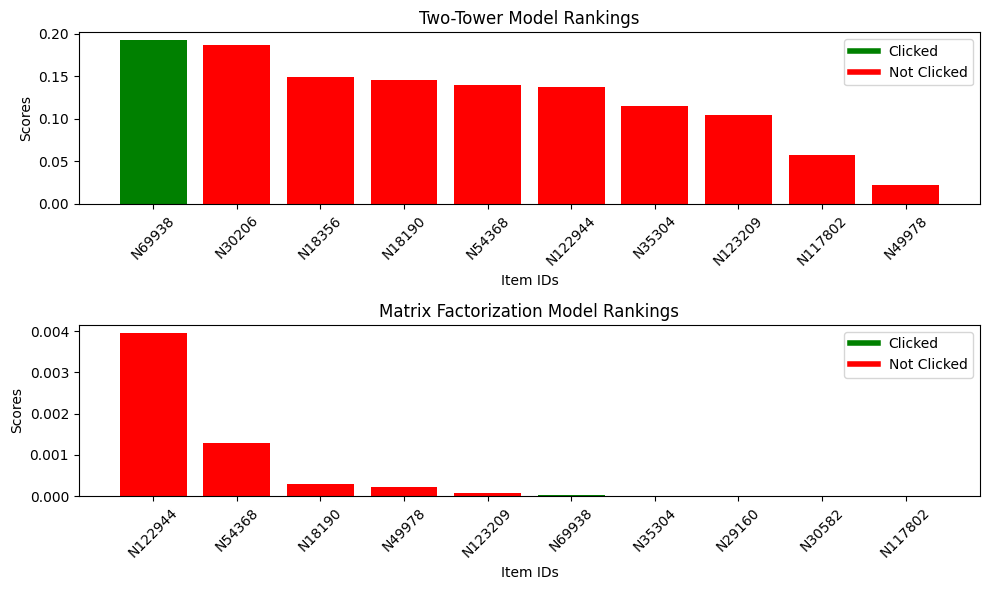

In [50]:
user_id = list(user_embeddings.keys())[0]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plot_ranking(user_id=user_id, df_impressions=df_val_impressions_seen, get_rankings_fn=tt_get_impression_rankings)
plt.title('Two-Tower Model Rankings')
plt.subplot(2, 1, 2)
plot_ranking(user_id=user_id, df_impressions=df_val_impressions_seen, get_rankings_fn=mf_get_impression_rankings, convert_idx_to_id=True)
plt.title('Matrix Factorization Model Rankings')
plt.tight_layout()
plt.show()

## Visualize embeddings with PCA
In this section, we visualize the user embedding and the items it has clicked on in a 2D space using PCA.

In [77]:
from sklearn.decomposition import PCA

def get_embeddings_for_user_tt(user_id, df_impressions):
    clicked_item_ids = set()
    impressions_for_user = df_impressions[df_impressions['user_id'] == user_id]
    for _, row in impressions_for_user.iterrows():
        for item_id, label in zip(row['news_ids'], row['labels']):
            if label == 1:
                clicked_item_ids.add(item_id)

    other_item_ids = set(item_embeddings.keys()) - clicked_item_ids
    user_emb = user_embeddings[user_id]
    clicked_items_embs = np.array([item_embeddings[item_id] for item_id in clicked_item_ids])
    other_items_embs = np.array([item_embeddings[item_id] for item_id in other_item_ids])

    return user_emb, clicked_items_embs, other_items_embs

def get_embeddings_for_user_mf(user_id, df_impressions):
    user_idx = converters_mf['user_id_to_idx'][user_id]
    clicked_item_idxs = set()
    impressions_for_user = df_impressions[df_impressions['user_id'] == user_id]
    for _, row in impressions_for_user.iterrows():
        for item_id, label in zip(row['news_ids'], row['labels']):
            if label == 1 and item_id in converters_mf['news_id_to_idx']:
                clicked_item_idxs.add(converters_mf['news_id_to_idx'][item_id])

    other_item_idxs = set(range(mf_model.item_factors.shape[0])) - clicked_item_idxs
    user_emb = mf_model.user_factors[user_idx]
    clicked_items_embs = mf_model.item_factors[list(clicked_item_idxs)]
    other_items_embs = mf_model.item_factors[list(other_item_idxs)]

    return user_emb, clicked_items_embs, other_items_embs

def plot_embeddings_pca(user_emb, clicked_items_embs, other_items_embs):
    pca = PCA(n_components=2)
    all_embs = np.vstack([user_emb[np.newaxis, :], clicked_items_embs, other_items_embs])
    pca_result = pca.fit_transform(all_embs)

    plt.scatter(pca_result[1+len(clicked_items_embs):, 0], pca_result[1+len(clicked_items_embs):, 1], color='gray', label='Other Items', alpha=0.05)
    plt.scatter(pca_result[1:1+len(clicked_items_embs), 0], pca_result[1:1+len(clicked_items_embs), 1], color='blue', label='Clicked Items', alpha=1)
    plt.scatter(pca_result[0, 0], pca_result[0, 1], color='red', label='User Embedding', s=50, marker='X', linewidths=0.1)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    return pca

In [79]:
# To get a sensible visualization, we need a user that has clicked on at least a few items
# Lets choose a random user with at least 30 clicks
user_click_counts = {}
for _, row in tqdm(df_val_impressions.iterrows(), total=len(df_val_impressions)):
    user_id = row['user_id']
    for item_id, label in zip(row['news_ids'], row['labels']):
        if label == 1:
            if user_id not in user_click_counts:
                user_click_counts[user_id] = 0
            user_click_counts[user_id] += 1
user_id = None
for uid, count in user_click_counts.items():
    if count >= 30:
        user_id = uid
        break
print(f"Selected user ID for visualization: {user_id} with {user_click_counts[user_id]} clicks")

  0%|          | 0/376471 [00:00<?, ?it/s]

Selected user ID for visualization: U286922 with 31 clicks


Plotting embeddings...


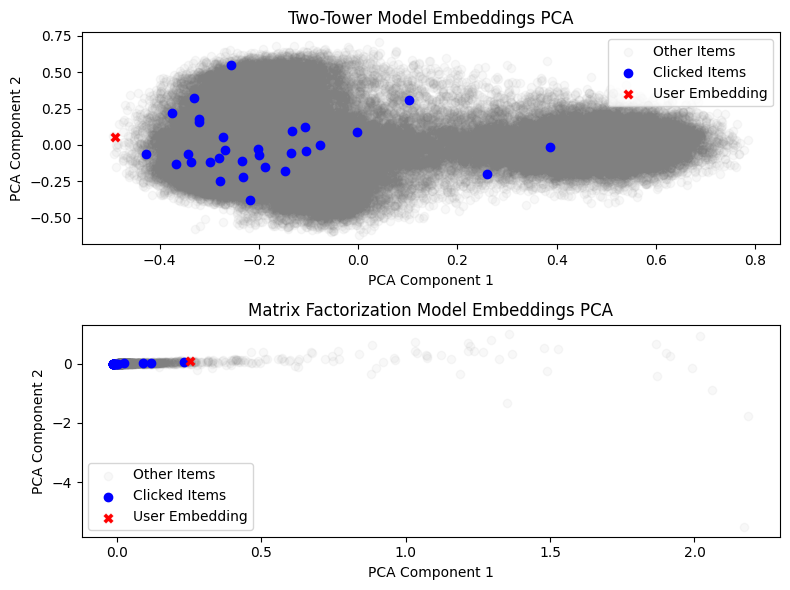

In [80]:
print("Collecting embeddings for user for Two-Tower model...")
user_emb_tt, clicked_items_embs_tt, other_items_embs_tt = get_embeddings_for_user_tt(user_id, df_val_impressions)
print("Collecting embeddings for user for Matrix Factorization model...")
user_emb_mf, clicked_items_embs_mf, other_items_embs_mf = get_embeddings_for_user_mf(user_id, df_val_impressions)

print("Plotting embeddings...")
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plot_embeddings_pca(user_emb_tt, clicked_items_embs_tt, other_items_embs_tt)
plt.title('Two-Tower Model Embeddings PCA')

plt.subplot(2, 1, 2)
plot_embeddings_pca(user_emb_mf, clicked_items_embs_mf, other_items_embs_mf)
plt.title('Matrix Factorization Model Embeddings PCA')

plt.tight_layout()
plt.show()